In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from os import listdir
import os
import sys
sys.path.insert(0, os.path.abspath('..')) # Note that this line is useless with a regular pip installation of PyWST.
import pywst as pw
%matplotlib inline


In [2]:
def PS_3D(dat_,box_size,npix,v_max,v_min,delta_v,freq_min,freq_max,nbins):
    #path_cs == Path to cosmological signal fits file 
    #npix == Number of pixels n (in n x n slice)
    #box_size == Box size to the nearest Mpc
    #v_max == Highest Frequency in range (MHz)
    #v_min == Lowest Frequency in range (MHz)
    #delta_v == Frequency step in MHz
    #v_interest == frequency the power spectrum is to be taken at (nearest 0.5MHz)
    #delta_freq == Frequency slice 
    #nbins == number of bins
    import numpy as np
    from numpy import fft as f 
    from astropy.io import fits
    import os 
    import matplotlib.pyplot as plt
    from astropy.cosmology import FlatLambdaCDM,WMAP9
    import astropy.units as u 
    import numpy as np
    from numpy import fft as f 
    import math 
    from astropy.io import fits
    import matplotlib.pyplot as plt
    import sys 
    print('\nu_{min}: ',freq_min)
    print('\nu_{max}: ',freq_max)
    box_size = float(box_size)
    freq_range_ = np.arange(v_min,v_max+delta_v, delta_v) 
    d1 =  dat_[freq_range_<=freq_max]
    f1 = freq_range_[freq_range_<=freq_max]
    dat = d1[freq_min <=f1]
    freq_range = f1[freq_min <=f1]
    
    delta_freq = freq_min-freq_max
    print('nu range:', freq_range)
    print(' ')
    print(' ')
    if delta_freq > 10:
        print('Having a bandwidth of 10MHz leads to more evolution in the signal!')
    H_0 = 69.32#Hubble constant 
    omega_m = WMAP9.Om0
    n_slices = (dat.shape)[0]
    zmin=1420/v_min - 1
    zmax=1420/v_max - 1
    dmin  = WMAP9.comoving_distance(zmin)
    dmax  = WMAP9.comoving_distance(zmax)
    delta_d = abs(dmax-dmin)
    k_small_perp = (2*np.pi)/box_size 
    k_large_perp = npix*k_small_perp #length of box side in k-space 
    k_small_los = (2*(np.pi)/delta_d)*u.Mpc
    k_large_los = k_small_los*n_slices 
    dat_3D = dat
    ft3d = f.fftn(dat_3D)/np.int(dat_3D.size)
    ft3d = f.fftshift(ft3d)
    PS3D = np.abs(ft3d)**2  
    if k_small_los<k_small_perp:
        k_small = k_small_los
    else:
        k_small = k_small_perp    
    if k_large_los<k_large_perp:
        k_largest = k_large_perp
    else:
        k_largest = k_large_los
    bins = np.logspace(math.log10(k_small),math.log10(k_largest ), nbins+1)
    dk_xy = (box_size/npix)/(2*np.pi)
    dk_z = (delta_d/n_slices)/(2*np.pi)
    nu_xy = np.fft.fftshift(np.fft.fftfreq(npix, dk_xy)) 
    nu_z = np.fft.fftshift(np.fft.fftfreq(n_slices, dk_z)) 
    kx, ky = np.meshgrid(nu_xy,nu_xy)
    cube_z = np.zeros((len(nu_z),kx.shape[0],kx.shape[1]))
    for o,c in zip(nu_z,range(len(nu_z))):
        cube_z[c,:,:] = o
    cube_z = np.array(cube_z)  
    ps = np.array(PS3D) 
    kmod = np.zeros((cube_z.shape[0],cube_z.shape[1],cube_z.shape[2]))
    for p in range(cube_z.shape[0]):
        kmod[p,:,:] = np.sqrt(kx**2 + ky**2 + cube_z[p]**2)
    kernel_1 = []
    kernel_2 = []
    k = np.zeros(nbins)
    for p in range(len(bins)-1):
        c1 = bins[p] <=kmod
        c2 =kmod[c1]< bins[p+1] 
        kernel_1.append(c1)
        kernel_2.append(c2)
        k[p] = bins[p+1]*100/H_0
    binned_data =np.zeros(nbins) #The binning of the FT
    ps_err=np.zeros(nbins)
    for bin_num in range(len(bins)-1):
        p1 = ps[kernel_1[bin_num]]
        bin_data = p1[kernel_2[bin_num]]
        volme = (box_size*box_size*delta_d)/u.Mpc
        prefac = (volme/(2*(np.pi)**2))   
        binned_data[bin_num] = (prefac*(np.mean(bin_data))*k[bin_num]**3)               
        PSerror =np.var(bin_data)/len(bin_data)
        ps_err[bin_num] =  PSerror          
    r = 3*(box_size/npix)
    maxkplot =   (2*np.pi)/(r)      
    #tl = np.array(k) < maxkplot
    #k= np.array(k)[tl]
    #binned_data = np.array(binned_data)[tl]  
    #ps_err = np.array(ps_err)[tl] 
    return binned_data,k,ps_err

In [3]:
def get_anisotropy(RWST_Object,plot = False):
    S1Iso = pow(2,RWST_Object.get_coeffs('S1Iso'))
 
    S1Aniso = pow(2,RWST_Object.get_coeffs('S1Aniso'))
    x = np.arange(RWST_Object.J)
    Aniso = S1Aniso/S1Iso
    if plot:
        plt.plot(x,Aniso)
        plt.xlabel('J',fontsize = 11)
        plt.ylabel('$\\frac{\hat{S}^{aniso}_{1}}{\hat{S}^{iso}_{1}}$',fontsize=11)
    return Aniso,x

In [4]:
plt_dir ='/Users/ianhothi/Dropbox/WST_RWST/Figures/lightcone_test/'
ddir = '/Users/ianhothi/WST/Testing/pywst/examples/data/'

In [5]:
lc = fits.getdata(ddir+'fx_0.1_RHS=0.5_fa_0.5_x_lightcone_dtb_fullres.fits')
LC = np.zeros((8,256,256,256))

In [6]:
z6 = 1/7.0
z15 = 1/16.0

a = np.linspace(z6,z15,lc.shape[0])
z = np.array([(1/i) - 1 for i in a])
Freqs = [1420/(1+i) for i in z]

In [7]:
LC[0] = lc[0:256,:,:] 
z0 = np.mean(z[::-1][0:256])
LC[1] = lc[256:512,:,:]
z1 = np.mean(z[::-1][256:512])
LC[2] = lc[512:(512+256),:,:]
z2 = np.mean(z[::-1][512:(512+256)])
LC[3] = lc[(512+256):(1024),:,:]
z3 = np.mean(z[::-1][(512+256):(1024)])
LC[4] = lc[(1024):(1024+256),:,:]
z4 = np.mean(z[::-1][(1024):(1024+256)])
LC[5] = lc[(1024+256):(1024+512),:,:]
z5 = np.mean(z[::-1][(1024+256):(1024+512)])
LC[6] = lc[(1024+512):(1024+512+256),:,:]
z6 = np.mean(z[::-1][(1024+512):(1024+512+256)])
LC[7] = lc[(1024+512+256):(1024+512+512),:,:]
z7 = np.mean(z[::-1][(1024+512+256):(1024+512+512)])

redshifts = ['$\\bar{z}$ ='+np.str(round(z0,2)),'$\\bar{z}$ ='+np.str(round(z1,2)),
            '$\\bar{z}$ ='+np.str(round(z2,2)),'$\\bar{z}$ ='+np.str(round(z3,2)),
            '$\\bar{z}$ ='+np.str(round(z4,2)),'$\\bar{z}$ ='+np.str(round(z5,2)),
            '$\\bar{z}$ ='+np.str(round(z6,2)),'$\\bar{z}$ ='+np.str(round(z7,2))]

/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/ipykernel_launcher.py:2

/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/ipykernel_launch

Text(0.5, 1.0, '$\\bar{z}$ =6.26')

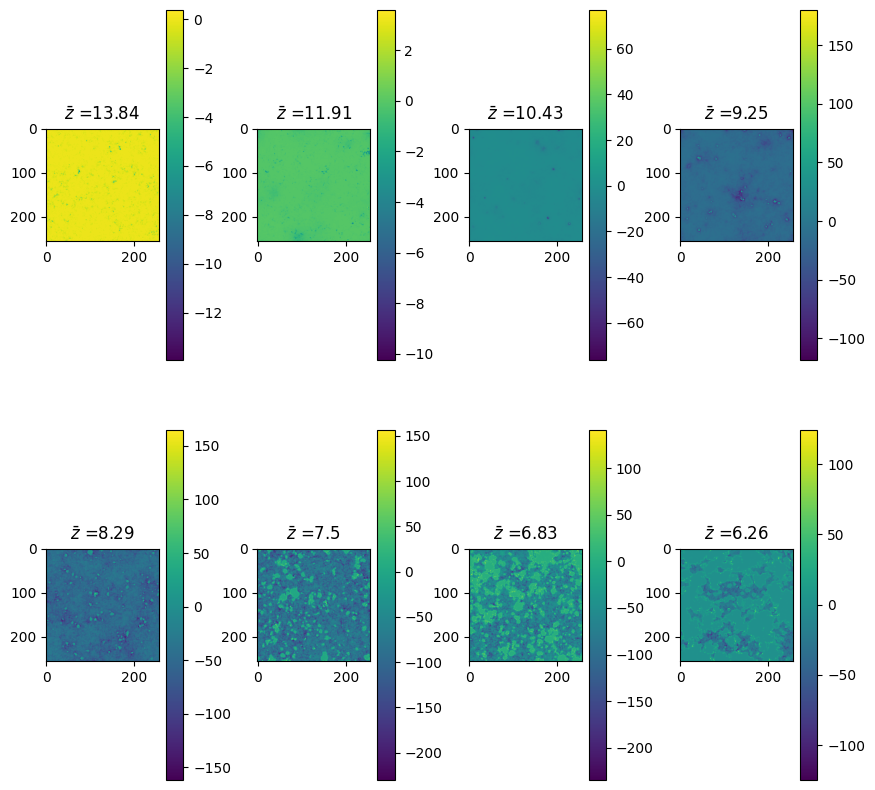

In [8]:
f, axarr = plt.subplots(2,4,figsize=(10, 10))
plt.subplots_adjust(wspace=0.5)
img = axarr[0,0].imshow(LC[0][0])
plt.colorbar(img, ax=axarr[0,0])
axarr[0,0].set_title('$\\bar{z}$ ='+np.str(round(z0,2)))

img = axarr[0,1].imshow(LC[1][0])
plt.colorbar(img, ax=axarr[0,1])
axarr[0,1].set_title('$\\bar{z}$ ='+np.str(round(z1,2)))

img = axarr[0,2].imshow(LC[2][0])
plt.colorbar(img, ax=axarr[0,2])
axarr[0,2].set_title('$\\bar{z}$ ='+np.str(round(z2,2)))

img = axarr[0,3].imshow(LC[3][0])
plt.colorbar(img, ax=axarr[0,3])
axarr[0,3].set_title('$\\bar{z}$ ='+np.str(round(z3,2)))

img = axarr[1,0].imshow(LC[4][0])
plt.colorbar(img, ax=axarr[1,0])
axarr[1,0].set_title('$\\bar{z}$ ='+np.str(round(z4,2)))

img = axarr[1,1].imshow(LC[5][0])
plt.colorbar(img, ax=axarr[1,1])
axarr[1,1].set_title('$\\bar{z}$ ='+np.str(round(z5,2)))

img = axarr[1,2].imshow(LC[6][0])
plt.colorbar(img, ax=axarr[1,2])
axarr[1,2].set_title('$\\bar{z}$ ='+np.str(round(z6,2)))

img = axarr[1,3].imshow(LC[7][0])
plt.colorbar(img, ax=axarr[1,3])
axarr[1,3].set_title('$\\bar{z}$ ='+np.str(round(z7,2)))

In [9]:
M, N = 256,256 # Height and width of the test maps
J = 8 # We choose to probe 7 scales
L = 8 # Number of angles in which the interval [0,pi] is divided
OS = 0 # No oversampling

In [10]:
wst_op = pw.WSTOp(M, N, J, L, OS)
rwst_op = pw.RWSTOp(M, N, J, L, OS)

In [11]:
WST_0 = wst_op.apply(LC[0][:100])
WST_0.normalize()
WST_0.average()

WST_1 = wst_op.apply(LC[1][:100])
WST_1.normalize()
WST_1.average()

WST_2 = wst_op.apply(LC[2][:100])
WST_2.normalize()
WST_2.average()

WST_3 = wst_op.apply(LC[3][:100])
WST_3.normalize()
WST_3.average()

WST_4 = wst_op.apply(LC[4][:100])
WST_4.normalize()
WST_4.average()

WST_5 = wst_op.apply(LC[5][:100])
WST_5.normalize()
WST_5.average()

WST_6 = wst_op.apply(LC[6][:100])
WST_6.normalize()
WST_6.average()

WST_7 = wst_op.apply(LC[7][:100])
WST_7.normalize()
WST_7.average()


In [12]:
WST_0.get_coeffs(layer=1,j1 = 0)

(array([0.0213969 , 0.02118556, 0.02076612, 0.0212196 , 0.02150737,
        0.02125075, 0.02077655, 0.02118767]),
 array([[1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 2., 3., 4., 5., 6., 7.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]]))

In [13]:
WST_0 = wst_op.apply(LC[0][:100])
WST_0.normalize()
WST_0.average()

WST_1 = wst_op.apply(LC[1][:100])
WST_1.normalize()
WST_1.average()

WST_2 = wst_op.apply(LC[2][:100])
WST_2.normalize()
WST_2.average()

WST_3 = wst_op.apply(LC[3][:100])
WST_3.normalize()
WST_3.average()

WST_4 = wst_op.apply(LC[4][:100])
WST_4.normalize()
WST_4.average()

WST_5 = wst_op.apply(LC[5][:100])
WST_5.normalize()
WST_5.average()

WST_6 = wst_op.apply(LC[6][:100])
WST_6.normalize()
WST_6.average()

WST_7 = wst_op.apply(LC[7][:100])
WST_7.normalize()
WST_7.average()


In [14]:
RWST_0 = rwst_op.apply(LC[0][:100],wst_average=True)
RWST_1 = rwst_op.apply(LC[1][:100],wst_average=True)
RWST_2 = rwst_op.apply(LC[2][:100],wst_average=True)
RWST_3 = rwst_op.apply(LC[3][:100],wst_average=True)
RWST_4 = rwst_op.apply(LC[4][:100],wst_average=True)
RWST_5 = rwst_op.apply(LC[5][:100],wst_average=True)
RWST_6 = rwst_op.apply(LC[6][:100],wst_average=True)
RWST_7 = rwst_op.apply(LC[7][:100],wst_average=True)

/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/pywst/wst.py:219: RuntimeWarning: invalid value encountered in log2
  self.coeffs = np.log2(self.coeffs)


In [15]:
def get_s21(wst_object, plot = False):
    import pywst as pw
    import numpy as np
    import matplotlib.pyplot as plt
    J = wst_object.J
    L = wst_object.L
    def get_coeffs_full(wst_object, J,L,Layer):
        def chunks(lst, J,L,Layer):
            Final = []
            if Layer == 1:
                Final = np.array([np.mean(lst[i:i + L]) for i in range(0, len(lst), L)])
            if Layer == 2:
                Final_to_Average = np.array([lst[i:i + J] for i in range(0, len(lst), J)])
                Final = np.array([np.mean(Final_to_Average[i:i + L]) for i in range(0, len(Final_to_Average), L)])

                
            return Final

        J1s = []
        for i in range(J):
            Coeffs,_ = wst_object.get_coeffs(layer=Layer,j1 = i)
            d = chunks(Coeffs,J,L,Layer)
            J1s.append(d) 
        return J1s
    Coeffs_s2 =  get_coeffs_full(wst_object,J,L,2)
    Coeffs_s1 =  get_coeffs_full(wst_object,J,L,1)
    
    Coeffs_s21 = [np.array(Coeffs_s2[i])/Coeffs_s1[i] for i in range(J)]
    if plot:
        fig, axs = plt.subplots(1, len(Coeffs_s21), sharey=True,figsize=(15,5))
        fig.subplots_adjust(wspace=0.07)
        for i in range(len(Coeffs_s21)):
            x = np.arange(J-i)
            axs[i].plot(Coeffs_s21[i])
            axs[i].set_title('$J_{1}$ = '+ np.str(i),fontsize=11)
            axs[i].set_xlabel('$J_{2}$',fontsize=11)
            axs[i].set_xticks(x,fontsize=11)
    
        axs[0].set_ylabel('$S_{2,1}$',fontsize=11)
        
    return Coeffs_s21
    
    

In [16]:
Sparsity_0 = get_s21(WST_0)
Sparsity_1 = get_s21(WST_1)
Sparsity_2 = get_s21(WST_2)
Sparsity_3 = get_s21(WST_3)
Sparsity_4 = get_s21(WST_4)
Sparsity_5 = get_s21(WST_5)
Sparsity_6 = get_s21(WST_6)
Sparsity_7 = get_s21(WST_7)

In [17]:
LC[0] = lc[0:256,:,:] 
z0_100 = round(np.mean(z[::-1][0:256][:100]),3)
LC[1] = lc[256:512,:,:]
z1_100 = round(np.mean(z[::-1][256:512][:100]),3)
LC[2] = lc[512:(512+256),:,:]
z2_100 = round(np.mean(z[::-1][512:(512+256)][:100]),3)
LC[3] = lc[(512+256):(1024),:,:]
z3_100 = round(np.mean(z[::-1][(512+256):(1024)][:100]),3)
LC[4] = lc[(1024):(1024+256),:,:]
z4_100 = round(np.mean(z[::-1][(1024):(1024+256)][:100]),3)
LC[5] = lc[(1024+256):(1024+512),:,:]
z5_100 = round(np.mean(z[::-1][(1024+256):(1024+512)][:100]),3)
LC[6] = lc[(1024+512):(1024+512+256),:,:]
z6_100 = round(np.mean(z[::-1][(1024+512):(1024+512+256)][:100]),3)
LC[7] = lc[(1024+512+256):(1024+512+512),:,:]
z7_100 = round(np.mean(z[::-1][(1024+512+256):(1024+512+512)][:100]),3)

redshifts_100 = ['$\\bar{z}$ ='+np.str(round(z0_100,2)),'$\\bar{z}$ ='+np.str(round(z1_100,2)),
            '$\\bar{z}$ ='+np.str(round(z2_100,2)),'$\\bar{z}$ ='+np.str(round(z3_100,2)),
            '$\\bar{z}$ ='+np.str(round(z4_100,2)),'$\\bar{z}$ ='+np.str(round(z5_100,2)),
            '$\\bar{z}$ ='+np.str(round(z6_100,2)),'$\\bar{z}$ ='+np.str(round(z7_100,2))]

/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/ipykernel_launcher.py:2

/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


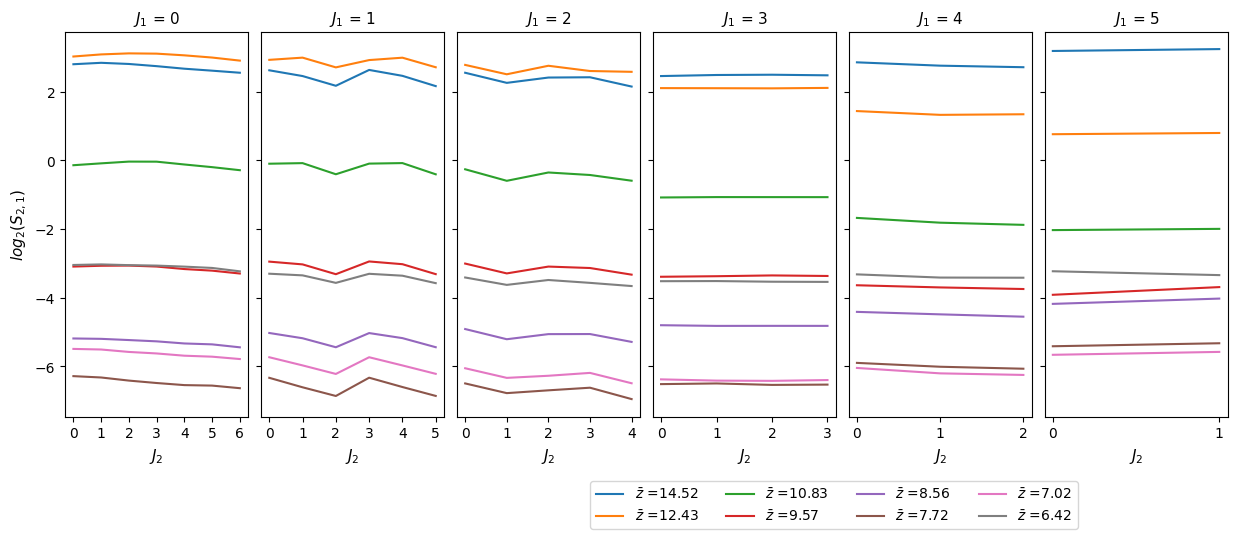

In [38]:
fig, axs = plt.subplots(1, len(Sparsity_0)-2, sharey=True,figsize=(15,5))
fig.subplots_adjust(wspace=0.07)
for i in range(len(Sparsity_0)-2):
    x = np.arange(len(Sparsity_0[i]))
    axs[i].plot(np.log2(Sparsity_0[i]),label = redshifts_100[0])
    axs[i].plot(np.log2(Sparsity_1[i]),label = redshifts_100[1])
    axs[i].plot(np.log2(Sparsity_2[i]),label = redshifts_100[2])
    axs[i].plot(np.log2(Sparsity_3[i]),label = redshifts_100[3])
    axs[i].plot(np.log2(Sparsity_4[i]),label = redshifts_100[4])
    axs[i].plot(np.log2(Sparsity_5[i]),label = redshifts_100[5])
    axs[i].plot(np.log2(Sparsity_6[i]),label = redshifts_100[6])
    axs[i].plot(np.log2(Sparsity_7[i]),label = redshifts_100[7])
    axs[i].set_title('$J_{1}$ = '+ np.str(i),fontsize=11)
    axs[i].set_xlabel('$J_{2}$',fontsize=11)
    axs[i].set_xticks(x,fontsize=11)
    
axs[0].set_ylabel('$log_2(S_{2,1})$',fontsize=11)
axs[0].legend(loc='upper center', bbox_to_anchor=(4.2, -0.15),
           ncol=4)

In [19]:
Anisotropy_0,Js = get_anisotropy(RWST_0)
Anisotropy_1,_ = get_anisotropy(RWST_1)
Anisotropy_2,_ = get_anisotropy(RWST_2)
Anisotropy_3,_ = get_anisotropy(RWST_3)
Anisotropy_4,_ = get_anisotropy(RWST_4)
Anisotropy_5,_ = get_anisotropy(RWST_5)
Anisotropy_6,_ = get_anisotropy(RWST_6)
Anisotropy_7,_ = get_anisotropy(RWST_7)

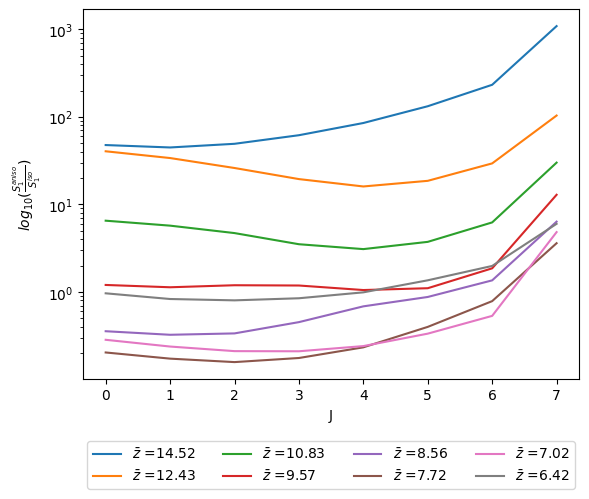

In [20]:
plt.plot(Js,Anisotropy_0,label = redshifts_100[0] )
plt.plot(Js,Anisotropy_1,label = redshifts_100[1] )
plt.plot(Js,Anisotropy_2,label = redshifts_100[2] )
plt.plot(Js,Anisotropy_3,label = redshifts_100[3] )
plt.plot(Js,Anisotropy_4,label = redshifts_100[4] )
plt.plot(Js,Anisotropy_5,label = redshifts_100[5] )
plt.plot(Js,Anisotropy_6,label = redshifts_100[6] )
plt.plot(Js,Anisotropy_7,label = redshifts_100[7] )
plt.legend()
plt.xlabel('J')
plt.ylabel('$log_{10} (\\frac{S^{aniso}_{1}}{S^{iso}_{1}}$)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.yscale('log')

In [21]:
z0s = z[::-1][0:256][:100]
nu_0 = [1420/(1+i) for i in z0s]
z1s = z[::-1][256:512][:100]
nu_1 = [1420/(1+i) for i in z1s]
z2s = z[::-1][512:(512+256)][:100]
nu_2 = [1420/(1+i) for i in z2s]
z3s = z[::-1][(512+256):(1024)][:100]
nu_3 = [1420/(1+i) for i in z3s]
z4s = z[::-1][(1024):(1024+256)][:100]
nu_4 = [1420/(1+i) for i in z4s]
z5s = z[::-1][(1024+256):(1024+512)][:100]
nu_5 = [1420/(1+i) for i in z5s]
z6s = z[::-1][(1024+512):(1024+512+256)][:100]
nu_6 = [1420/(1+i) for i in z6s]
z7s = z[::-1][(1024+512+256):(1024+512+512)][:100]
nu_7 = [1420/(1+i) for i in z7s]

In [22]:
PS_0,k_0,Err_0 = PS_3D(lc,128,256,np.array(Freqs).max(),np.array(Freqs).min(),Freqs[0]-Freqs[1],np.array(nu_0).min(),np.array(nu_0).max(),10)
PS_1,k_1,Err_1 = PS_3D(lc,128,256,np.array(Freqs).max(),np.array(Freqs).min(),Freqs[0]-Freqs[1],np.array(nu_1).min(),np.array(nu_1).max(),10)
PS_2,k_2,Err_2 = PS_3D(lc,128,256,np.array(Freqs).max(),np.array(Freqs).min(),Freqs[0]-Freqs[1],np.array(nu_2).min(),np.array(nu_2).max(),10)
PS_3,k_3,Err_3 = PS_3D(lc,128,256,np.array(Freqs).max(),np.array(Freqs).min(),Freqs[0]-Freqs[1],np.array(nu_3).min(),np.array(nu_3).max(),10)
PS_4,k_4,Err_4 = PS_3D(lc,128,256,np.array(Freqs).max(),np.array(Freqs).min(),Freqs[0]-Freqs[1],np.array(nu_4).min(),np.array(nu_4).max(),10)
PS_5,k_5,Err_5 = PS_3D(lc,128,256,np.array(Freqs).max(),np.array(Freqs).min(),Freqs[0]-Freqs[1],np.array(nu_5).min(),np.array(nu_5).max(),10)
PS_6,k_6,Err_6 = PS_3D(lc,128,256,np.array(Freqs).max(),np.array(Freqs).min(),Freqs[0]-Freqs[1],np.array(nu_6).min(),np.array(nu_6).max(),15)
PS_7,k_7,Err_7 = PS_3D(lc,128,256,np.array(Freqs).max(),np.array(Freqs).min(),Freqs[0]-Freqs[1],np.array(nu_7).min(),np.array(nu_7).max(),15)



u_{min}:  88.75

u_{max}:  94.26861609323748
nu range: [88.75       88.8057436  88.86148719 88.91723079 88.97297439 89.02871798
 89.08446158 89.14020518 89.19594878 89.25169237 89.30743597 89.36317957
 89.41892316 89.47466676 89.53041036 89.58615395 89.64189755 89.69764115
 89.75338474 89.80912834 89.86487194 89.92061553 89.97635913 90.03210273
 90.08784633 90.14358992 90.19933352 90.25507712 90.31082071 90.36656431
 90.42230791 90.4780515  90.5337951  90.5895387  90.64528229 90.70102589
 90.75676949 90.81251309 90.86825668 90.92400028 90.97974388 91.03548747
 91.09123107 91.14697467 91.20271826 91.25846186 91.31420546 91.36994905
 91.42569265 91.48143625 91.53717985 91.59292344 91.64866704 91.70441064
 91.76015423 91.81589783 91.87164143 91.92738502 91.98312862 92.03887222
 92.09461581 92.15035941 92.20610301 92.2618466  92.3175902  92.3733338
 92.4290774  92.48482099 92.54056459 92.59630819 92.65205178 92.70779538
 92.76353898 92.81928257 92.87502617 92.93076977 92.98651336 93.04225

/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



u_{min}:  103.02036080675553

u_{max}:  108.53897689999302
nu range: [103.02036081 103.0761044  103.131848   103.1875916  103.24333519
 103.29907879 103.35482239 103.41056599 103.46630958 103.52205318
 103.57779678 103.63354037 103.68928397 103.74502757 103.80077116
 103.85651476 103.91225836 103.96800195 104.02374555 104.07948915
 104.13523274 104.19097634 104.24671994 104.30246354 104.35820713
 104.41395073 104.46969433 104.52543792 104.58118152 104.63692512
 104.69266871 104.74841231 104.80415591 104.8598995  104.9156431
 104.9713867  105.0271303  105.08287389 105.13861749 105.19436109
 105.25010468 105.30584828 105.36159188 105.41733547 105.47307907
 105.52882267 105.58456626 105.64030986 105.69605346 105.75179705
 105.80754065 105.86328425 105.91902785 105.97477144 106.03051504
 106.08625864 106.14200223 106.19774583 106.25348943 106.30923302
 106.36497662 106.42072022 106.47646381 106.53220741 106.58795101
 106.64369461 106.6994382  106.7551818  106.8109254  106.86666899
 106.92

/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



u_{min}:  188.64252564728872

u_{max}:  194.16114174052618
nu range: [188.64252565 188.69826924 188.75401284 188.80975644 188.86550003
 188.92124363 188.97698723 189.03273083 189.08847442 189.14421802
 189.19996162 189.25570521 189.31144881 189.36719241 189.422936
 189.4786796  189.5344232  189.59016679 189.64591039 189.70165399
 189.75739759 189.81314118 189.86888478 189.92462838 189.98037197
 190.03611557 190.09185917 190.14760276 190.20334636 190.25908996
 190.31483355 190.37057715 190.42632075 190.48206435 190.53780794
 190.59355154 190.64929514 190.70503873 190.76078233 190.81652593
 190.87226952 190.92801312 190.98375672 191.03950031 191.09524391
 191.15098751 191.2067311  191.2624747  191.3182183  191.3739619
 191.42970549 191.48544909 191.54119269 191.59693628 191.65267988
 191.70842348 191.76416707 191.81991067 191.87565427 191.93139786
 191.98714146 192.04288506 192.09862866 192.15437225 192.21011585
 192.26585945 192.32160304 192.37734664 192.43309024 192.48883383
 192.5445

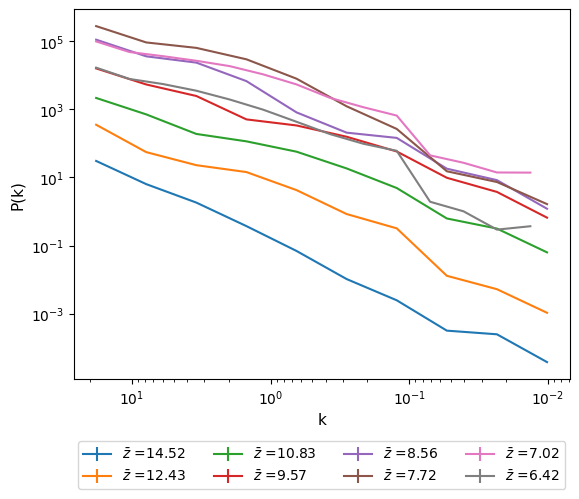

In [23]:
plt.errorbar(k_0,PS_0,yerr=Err_0, label = redshifts_100[0])
plt.errorbar(k_1,PS_1,yerr=Err_1, label = redshifts_100[1])
plt.errorbar(k_2,PS_2,yerr=Err_2, label = redshifts_100[2])
plt.errorbar(k_3,PS_3,yerr=Err_3, label = redshifts_100[3])
plt.errorbar(k_4,PS_4,yerr=Err_4, label = redshifts_100[4])
plt.errorbar(k_5,PS_5,yerr=Err_5, label = redshifts_100[5])
plt.errorbar(k_6,PS_6,yerr=Err_6, label = redshifts_100[6])
plt.errorbar(k_7,PS_7,yerr=Err_7, label = redshifts_100[7])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('P(k)',fontsize=11)
plt.xlabel('k',fontsize=11)
plt.gca().invert_xaxis()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)

/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/pywst/wst.py:217: UserWarning: Warning! The covariance matrix has already been computed with linear coefficients. We compute logarithmic errors from diagonal coefficients and discard off-diagonal coefficients.
  warnings.warn("Warning! The covariance matrix has already been computed with linear coefficients. We compute logarithmic errors from diagonal coefficients and discard off-diagonal coefficients.")
/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/pywst/wst.py:219: RuntimeWarning: invalid value encountered in log2
  self.coeffs = np.log2(self.coeffs)


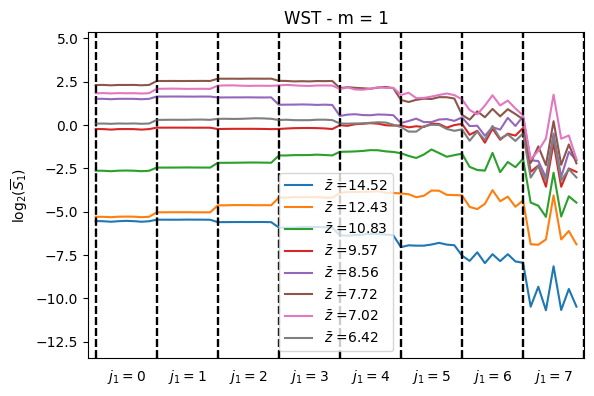

In [24]:
WST_0.to_log2().plot_compare([WST_1.to_log2(),WST_2.to_log2(),WST_3.to_log2(),WST_4.to_log2(),WST_5.to_log2(),WST_6.to_log2(),WST_7.to_log2()],layer = 1, labels= redshifts_100)

# Sparsity: $K_{\parallel} vs. K_{\perp}$

In [25]:
LC_ls = np.zeros((8,100,256,256))

In [26]:
LC_ls[0] = lc[0:256,:,:100].T
print(LC_ls.shape)
LC_ls[1] = lc[256:512,:,:100].T
LC_ls[2] = lc[512:(512+256),:,:100].T
LC_ls[3] = lc[(512+256):(1024),:,:100].T
LC_ls[4] = lc[(1024):(1024+256),:,:100].T
LC_ls[5] = lc[(1024+256):(1024+512),:,:100].T
LC_ls[6] = lc[(1024+512):(1024+512+256),:,:100].T
LC_ls[7] = lc[(1024+512+256):(1024+512+512),:,:100].T

(8, 100, 256, 256)


In [27]:
WST_0_ls = wst_op.apply(LC_ls[0][:100])
WST_0_ls.normalize()
WST_0_ls.average()

WST_1_ls = wst_op.apply(LC_ls[1][:100])
WST_1_ls.normalize()
WST_1_ls.average()

WST_2_ls = wst_op.apply(LC_ls[2][:100])
WST_2_ls.normalize()
WST_2_ls.average()

WST_3_ls = wst_op.apply(LC_ls[3][:100])
WST_3_ls.normalize()
WST_3_ls.average()

WST_4_ls = wst_op.apply(LC_ls[4][:100])
WST_4_ls.normalize()
WST_4_ls.average()

WST_5_ls = wst_op.apply(LC_ls[5][:100])
WST_5_ls.normalize()
WST_5_ls.average()

WST_6_ls = wst_op.apply(LC_ls[6][:100])
WST_6_ls.normalize()
WST_6_ls.average()

WST_7_ls = wst_op.apply(LC_ls[7][:100])
WST_7_ls.normalize()
WST_7_ls.average()


In [28]:
Sparsity_0_ls = get_s21(WST_0_ls)
Sparsity_1_ls = get_s21(WST_1_ls)
Sparsity_2_ls = get_s21(WST_2_ls)
Sparsity_3_ls = get_s21(WST_3_ls)
Sparsity_4_ls = get_s21(WST_4_ls)
Sparsity_5_ls = get_s21(WST_5_ls)
Sparsity_6_ls = get_s21(WST_6_ls)
Sparsity_7_ls = get_s21(WST_7_ls)

/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


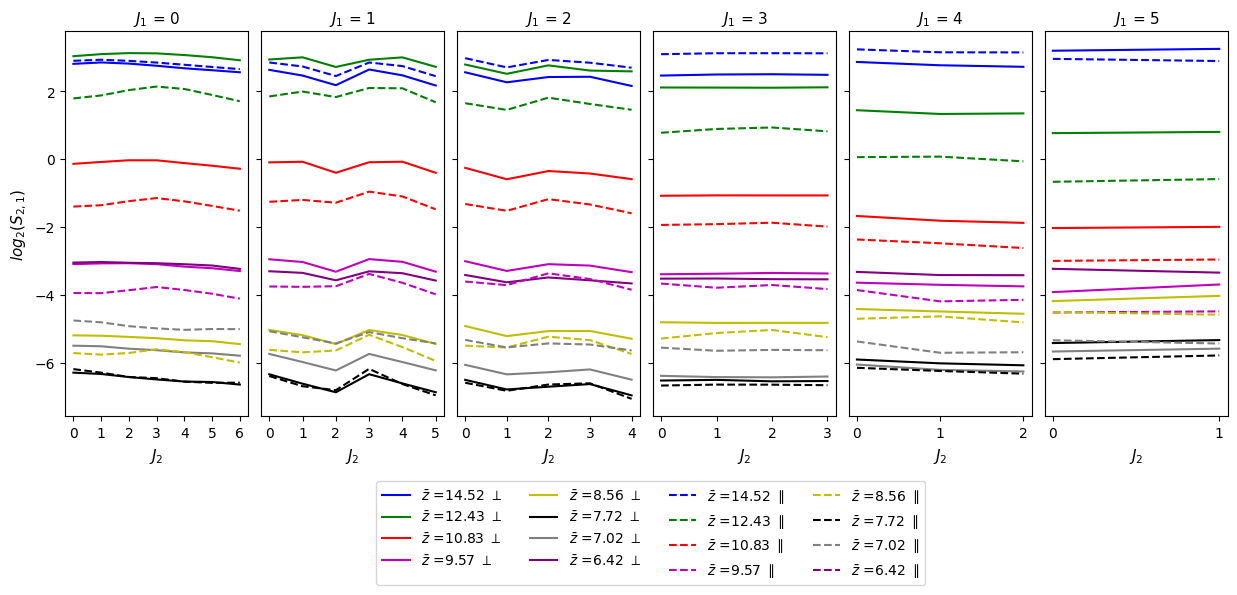

In [37]:
fig, axs = plt.subplots(1, len(Sparsity_0)-2, sharey=True,figsize=(15,5))
fig.subplots_adjust(wspace=0.07)
for i in range(len(Sparsity_0)-2):
    x = np.arange(len(Sparsity_0[i]))
    axs[i].plot(np.log2(Sparsity_0[i]),label = (redshifts_100[0])+' $\\perp$',c = 'b' )
    axs[i].plot(np.log2(Sparsity_1[i]),label = (redshifts_100[1])+' $\\perp$',c='g')
    axs[i].plot(np.log2(Sparsity_2[i]),label = (redshifts_100[2])+' $\\perp$',c='r')
    axs[i].plot(np.log2(Sparsity_3[i]),label = (redshifts_100[3])+' $\\perp$',c='m')
    axs[i].plot(np.log2(Sparsity_4[i]),label = (redshifts_100[4])+' $\\perp$',c='y')
    axs[i].plot(np.log2(Sparsity_5[i]),label = (redshifts_100[5])+' $\\perp$',c='black')
    axs[i].plot(np.log2(Sparsity_6[i]),label = (redshifts_100[6])+' $\\perp$',c='grey')
    axs[i].plot(np.log2(Sparsity_7[i]),label = (redshifts_100[7])+' $\\perp$',c='purple')
    axs[i].plot(np.log2(Sparsity_0_ls[i]),label = (redshifts_100[0])+' $\\parallel$',ls='--',c = 'b')
    axs[i].plot(np.log2(Sparsity_1_ls[i]),label = (redshifts_100[1])+' $\\parallel$',ls='--',c='g')
    axs[i].plot(np.log2(Sparsity_2_ls[i]),label = (redshifts_100[2])+' $\\parallel$',ls='--',c='r')
    axs[i].plot(np.log2(Sparsity_3_ls[i]),label = (redshifts_100[3])+' $\\parallel$',ls='--',c='m')
    axs[i].plot(np.log2(Sparsity_4_ls[i]),label = (redshifts_100[4])+' $\\parallel$',ls='--',c='y')
    axs[i].plot(np.log2(Sparsity_5_ls[i]),label = (redshifts_100[5])+' $\\parallel$',ls='--',c='black')
    axs[i].plot(np.log2(Sparsity_6_ls[i]),label = (redshifts_100[6])+' $\\parallel$',ls='--',c='grey')
    axs[i].plot(np.log2(Sparsity_7_ls[i]),label = (redshifts_100[7])+' $\\parallel$',ls='--',c='purple')
    axs[i].set_title('$J_{1}$ = '+ np.str(i),fontsize=11)
    axs[i].set_xlabel('$J_{2}$',fontsize=11)
    axs[i].set_xticks(x,fontsize=11)
    
axs[0].set_ylabel('$log_2(S_{2,1})$',fontsize=11)
axs[0].legend(loc='upper center', bbox_to_anchor=(3.2, -0.15),
           ncol=4)

In [41]:
RWST_0_ls = rwst_op.apply(LC_ls[0][:100],wst_average=True)
RWST_1_ls = rwst_op.apply(LC_ls[1][:100],wst_average=True)
RWST_2_ls = rwst_op.apply(LC_ls[2][:100],wst_average=True)
RWST_3_ls = rwst_op.apply(LC_ls[3][:100],wst_average=True)
RWST_4_ls = rwst_op.apply(LC_ls[4][:100],wst_average=True)
RWST_5_ls = rwst_op.apply(LC_ls[5][:100],wst_average=True)
RWST_6_ls = rwst_op.apply(LC_ls[6][:100],wst_average=True)
RWST_7_ls = rwst_op.apply(LC_ls[7][:100],wst_average=True)

/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/pywst/wst.py:219: RuntimeWarning: invalid value encountered in log2
  self.coeffs = np.log2(self.coeffs)


In [42]:
Anisotropy_0_ls,Js_ls = get_anisotropy(RWST_0_ls)
Anisotropy_1_ls,_ = get_anisotropy(RWST_1_ls)
Anisotropy_2_ls,_ = get_anisotropy(RWST_2_ls)
Anisotropy_3_ls,_ = get_anisotropy(RWST_3_ls)
Anisotropy_4_ls,_ = get_anisotropy(RWST_4_ls)
Anisotropy_5_ls,_ = get_anisotropy(RWST_5_ls)
Anisotropy_6_ls,_ = get_anisotropy(RWST_6_ls)
Anisotropy_7_ls,_ = get_anisotropy(RWST_7_ls)

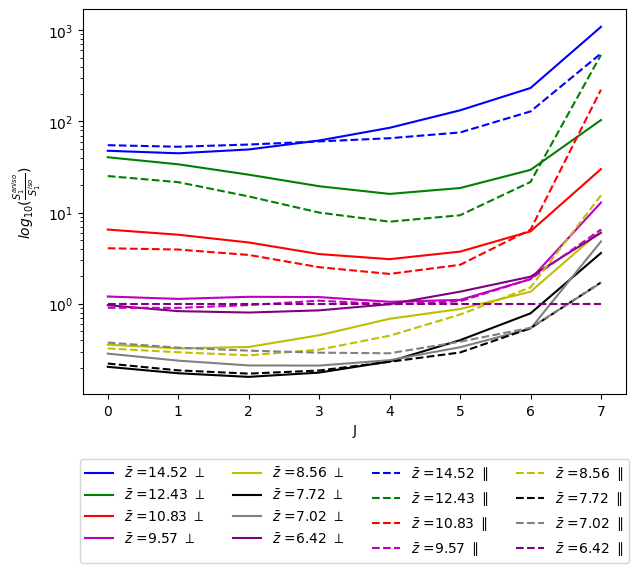

In [45]:
plt.figure(figsize=(7,5))
plt.plot(Js,Anisotropy_0,label = (redshifts_100[0])+' $\\perp$',c = 'b' )
plt.plot(Js,Anisotropy_1,label = (redshifts_100[1])+' $\\perp$',c='g' )
plt.plot(Js,Anisotropy_2,label = (redshifts_100[2])+' $\\perp$',c='r' )
plt.plot(Js,Anisotropy_3,label = (redshifts_100[3])+' $\\perp$',c='m' )
plt.plot(Js,Anisotropy_4,label = (redshifts_100[4])+' $\\perp$',c='y' )
plt.plot(Js,Anisotropy_5,label = (redshifts_100[5])+' $\\perp$',c='black')
plt.plot(Js,Anisotropy_6,label = (redshifts_100[6])+' $\\perp$',c='grey')
plt.plot(Js,Anisotropy_7,label = (redshifts_100[7])+' $\\perp$',c='purple' )
plt.plot(Js_ls,Anisotropy_0_ls,label = (redshifts_100[0])+' $\\parallel$',ls='--',c = 'b')
plt.plot(Js_ls,Anisotropy_1_ls,label = (redshifts_100[1])+' $\\parallel$',ls='--',c='g')
plt.plot(Js_ls,Anisotropy_2_ls,label = (redshifts_100[2])+' $\\parallel$',ls='--',c='r')
plt.plot(Js_ls,Anisotropy_3_ls,label = (redshifts_100[3])+' $\\parallel$',ls='--',c='m')
plt.plot(Js_ls,Anisotropy_4_ls,label = (redshifts_100[4])+' $\\parallel$',ls='--',c='y')
plt.plot(Js_ls,Anisotropy_5_ls,label = (redshifts_100[5])+' $\\parallel$',ls='--',c='black')
plt.plot(Js_ls,Anisotropy_6_ls,label = (redshifts_100[6])+' $\\parallel$',ls='--',c='grey')
plt.plot(Js_ls,Anisotropy_7_ls,label = (redshifts_100[7])+' $\\parallel$',ls='--',c='purple')
plt.legend()
plt.xlabel('J')
plt.ylabel('$log_{10} (\\frac{S^{aniso}_{1}}{S^{iso}_{1}}$)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.yscale('log')

# Different Redshifts and their Images 

/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


$\bar{z}$ =14.52
15.0
12.791145332050046


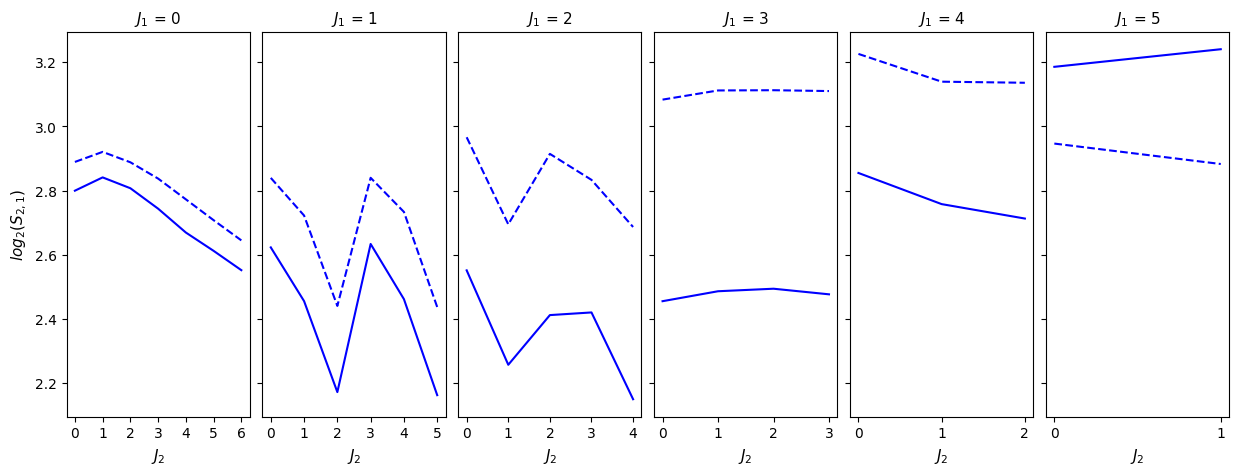

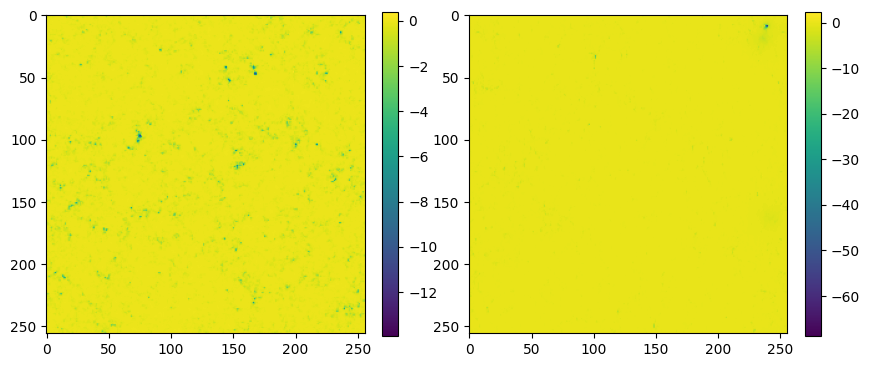

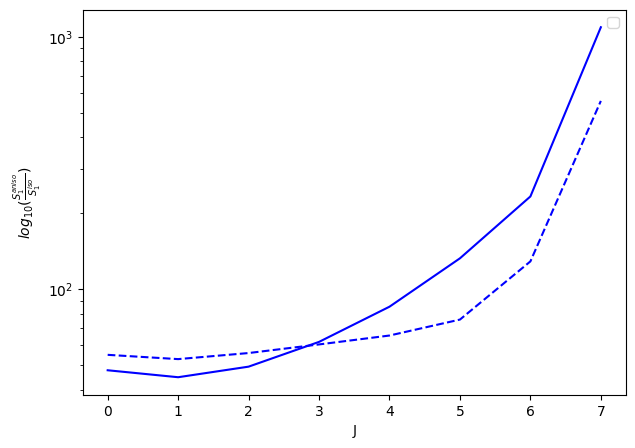

In [79]:
print(redshifts_100[0])
print(z[::-1][0:256].max())
print(z[::-1][0:256].min())
fig, axs = plt.subplots(1, len(Sparsity_0)-2, sharey=True,figsize=(15,5))
fig.subplots_adjust(wspace=0.07)
for i in range(len(Sparsity_0)-2):
    x = np.arange(len(Sparsity_0[i]))
    axs[i].plot(np.log2(Sparsity_0[i]),c = 'b' )
    axs[i].plot(np.log2(Sparsity_0_ls[i]),ls='--',c = 'b')
    axs[i].set_title('$J_{1}$ = '+ np.str(i),fontsize=11)
    axs[i].set_xlabel('$J_{2}$',fontsize=11)
    axs[i].set_xticks(x,fontsize=11)    
axs[0].set_ylabel('$log_2(S_{2,1})$',fontsize=11)

f, axarr = plt.subplots(1,2,figsize=(10, 10))
img = axarr[0].imshow(LC[0][0])
plt.colorbar(img, ax=axarr[0],fraction=0.046)
img = axarr[1].imshow(LC_ls[0][0])
plt.colorbar(img, ax=axarr[1],fraction=0.046)

plt.figure(figsize=(7,5))
plt.plot(Js,Anisotropy_0,c = 'b' )
plt.plot(Js_ls,Anisotropy_0_ls,ls='--',c = 'b')

plt.legend()
plt.xlabel('J')
plt.ylabel('$log_{10} (\\frac{S^{aniso}_{1}}{S^{iso}_{1}}$)')
plt.yscale('log')

/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


$\bar{z}$ =12.43
12.783683039740275
11.112426035502958


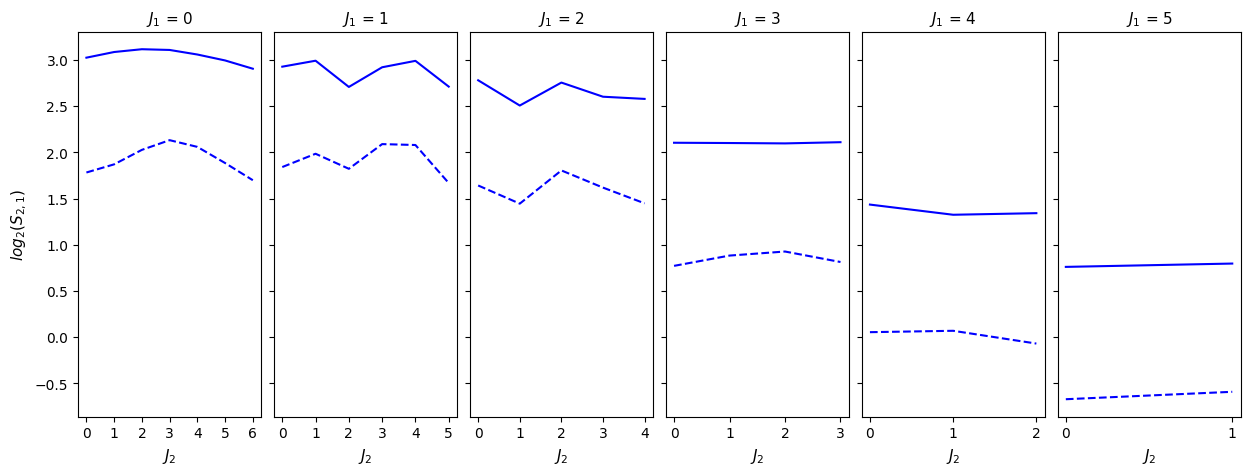

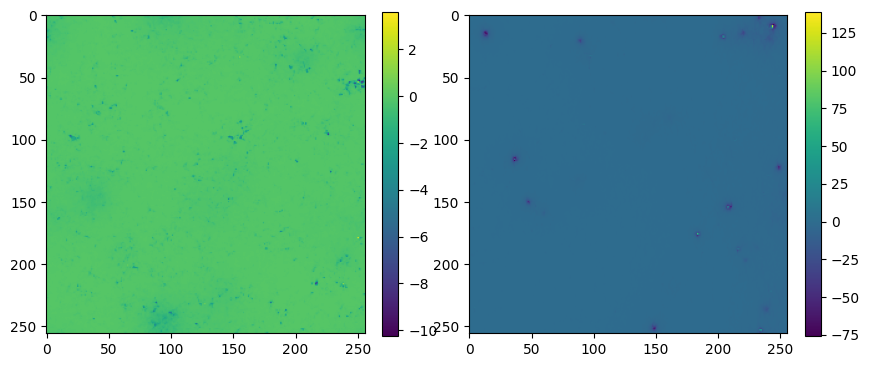

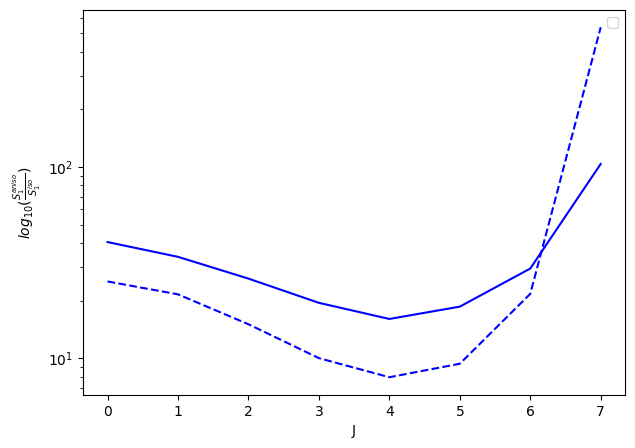

In [80]:
print(redshifts_100[1])
print(z[::-1][256:512].max())
print(z[::-1][256:512].min())

fig, axs = plt.subplots(1, len(Sparsity_1)-2, sharey=True,figsize=(15,5))
fig.subplots_adjust(wspace=0.07)
for i in range(len(Sparsity_1)-2):
    x = np.arange(len(Sparsity_1[i]))
    axs[i].plot(np.log2(Sparsity_1[i]),c = 'b' )
    axs[i].plot(np.log2(Sparsity_1_ls[i]),ls='--',c = 'b')
    axs[i].set_title('$J_{1}$ = '+ np.str(i),fontsize=11)
    axs[i].set_xlabel('$J_{2}$',fontsize=11)
    axs[i].set_xticks(x,fontsize=11)    
axs[0].set_ylabel('$log_2(S_{2,1})$',fontsize=11)

f, axarr = plt.subplots(1,2,figsize=(10, 10))
img = axarr[0].imshow(LC[1][0])
plt.colorbar(img, ax=axarr[0],fraction=0.046)
img = axarr[1].imshow(LC_ls[1][0])
plt.colorbar(img, ax=axarr[1],fraction=0.046)

plt.figure(figsize=(7,5))
plt.plot(Js,Anisotropy_1,c = 'b' )
plt.plot(Js_ls,Anisotropy_1_ls,ls='--',c = 'b')

plt.legend()
plt.xlabel('J')
plt.ylabel('$log_{10} (\\frac{S^{aniso}_{1}}{S^{iso}_{1}}$)')
plt.yscale('log')

/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


$\bar{z}$ =10.83
11.106669483022653
9.798040693293142


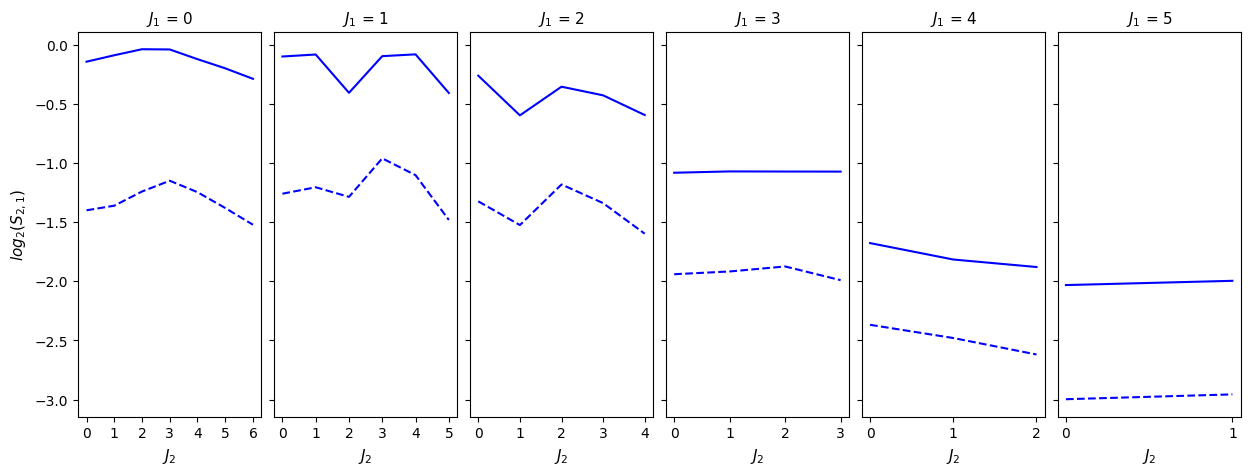

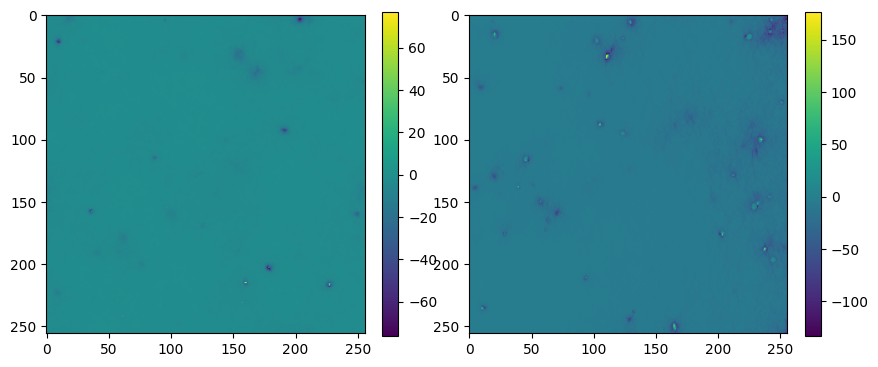

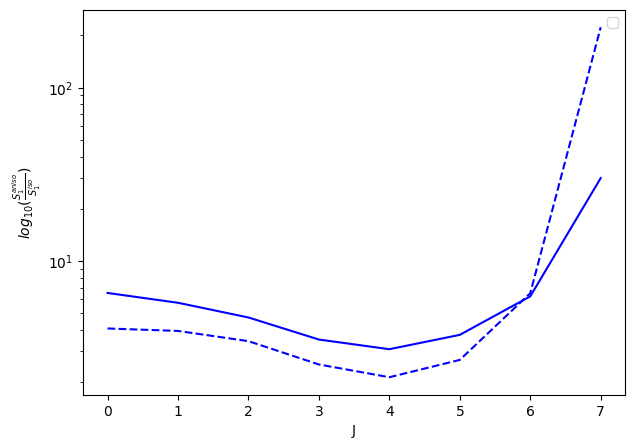

In [81]:
print(redshifts_100[2])
print(z[::-1][512:(512+256)].max())
print(z[::-1][512:(512+256)].min())
fig, axs = plt.subplots(1, len(Sparsity_2)-2, sharey=True,figsize=(15,5))
fig.subplots_adjust(wspace=0.07)
for i in range(len(Sparsity_2)-2):
    x = np.arange(len(Sparsity_2[i]))
    axs[i].plot(np.log2(Sparsity_2[i]),c = 'b' )
    axs[i].plot(np.log2(Sparsity_2_ls[i]),ls='--',c = 'b')
    axs[i].set_title('$J_{1}$ = '+ np.str(i),fontsize=11)
    axs[i].set_xlabel('$J_{2}$',fontsize=11)
    axs[i].set_xticks(x,fontsize=11)    
axs[0].set_ylabel('$log_2(S_{2,1})$',fontsize=11)

f, axarr = plt.subplots(1,2,figsize=(10, 10))
img = axarr[0].imshow(LC[2][0])
plt.colorbar(img, ax=axarr[0],fraction=0.046)
img = axarr[1].imshow(LC_ls[2][0])
plt.colorbar(img, ax=axarr[1],fraction=0.046)

plt.figure(figsize=(7,5))
plt.plot(Js,Anisotropy_2,c = 'b' )
plt.plot(Js_ls,Anisotropy_2_ls,ls='--',c = 'b')

plt.legend()
plt.xlabel('J')
plt.ylabel('$log_{10} (\\frac{S^{aniso}_{1}}{S^{iso}_{1}}$)')
plt.yscale('log')

/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


$\bar{z}$ =9.57
9.793465467727508
8.740992522093814


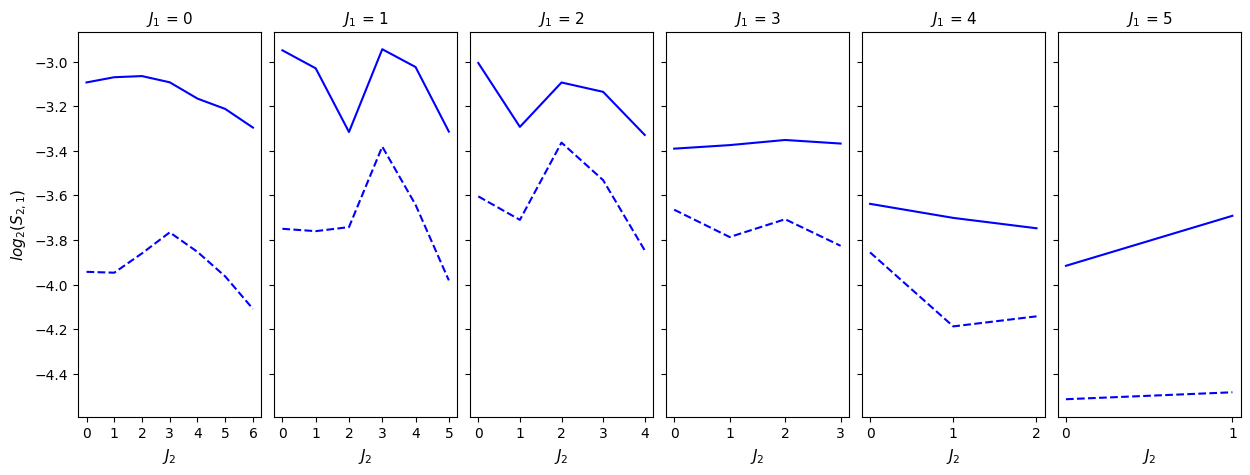

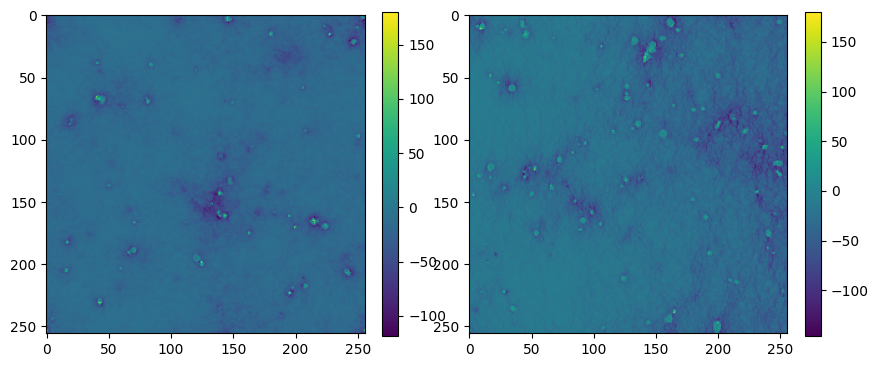

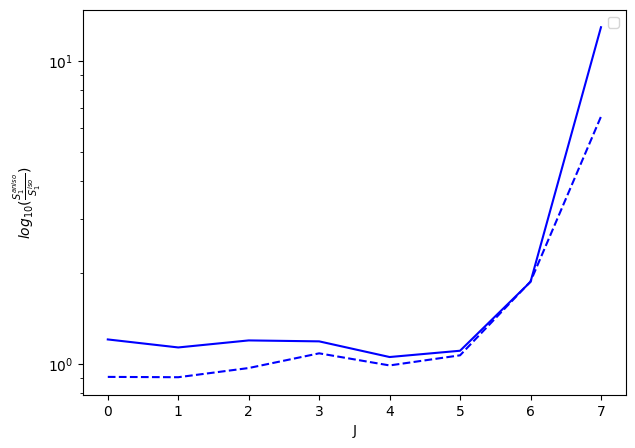

In [82]:
print(redshifts_100[3])
print(z[::-1][(512+256):(1024)].max())
print(z[::-1][(512+256):(1024)].min())
fig, axs = plt.subplots(1, len(Sparsity_3)-2, sharey=True,figsize=(15,5))
fig.subplots_adjust(wspace=0.07)
for i in range(len(Sparsity_3)-2):
    x = np.arange(len(Sparsity_3[i]))
    axs[i].plot(np.log2(Sparsity_3[i]),c = 'b' )
    axs[i].plot(np.log2(Sparsity_3_ls[i]),ls='--',c = 'b')
    axs[i].set_title('$J_{1}$ = '+ np.str(i),fontsize=11)
    axs[i].set_xlabel('$J_{2}$',fontsize=11)
    axs[i].set_xticks(x,fontsize=11)    
axs[0].set_ylabel('$log_2(S_{2,1})$',fontsize=11)

f, axarr = plt.subplots(1,2,figsize=(10, 10))
img = axarr[0].imshow(LC[3][0])
plt.colorbar(img, ax=axarr[0],fraction=0.046)
img = axarr[1].imshow(LC_ls[3][0])
plt.colorbar(img, ax=axarr[1],fraction=0.046)

plt.figure(figsize=(7,5))
plt.plot(Js,Anisotropy_3,c = 'b' )
plt.plot(Js_ls,Anisotropy_3_ls,ls='--',c = 'b')

plt.legend()
plt.xlabel('J')
plt.ylabel('$log_{10} (\\frac{S^{aniso}_{1}}{S^{iso}_{1}}$)')
plt.yscale('log')

$\bar{z}$ =8.56
8.737269059248248
7.8724458204334375


/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


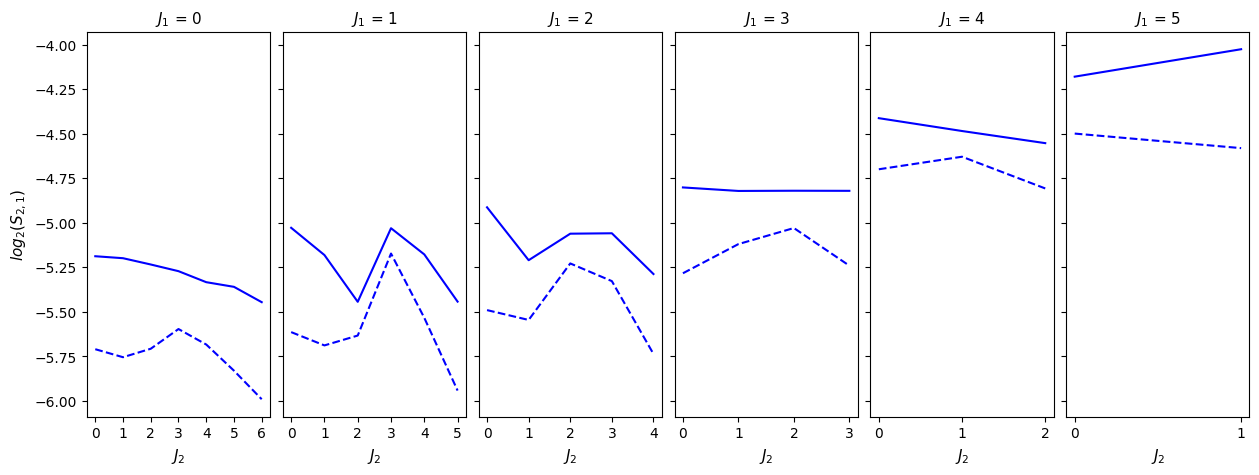

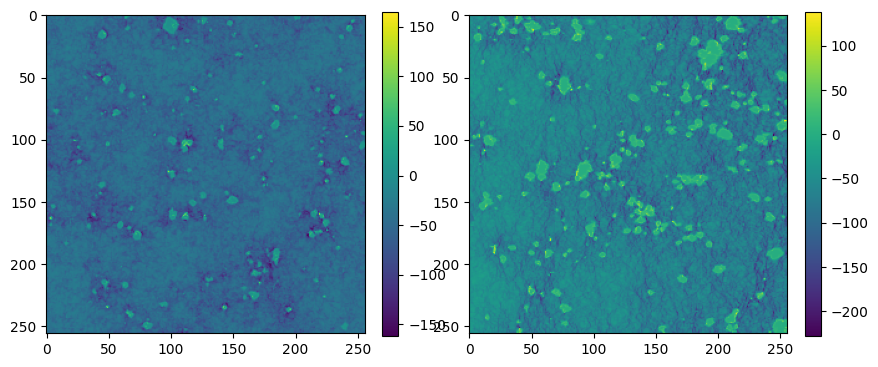

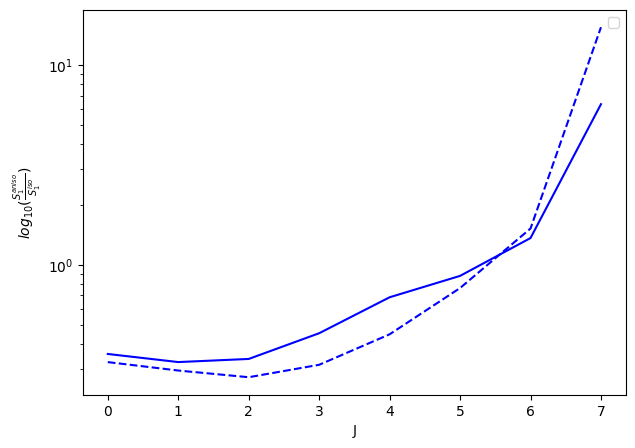

In [83]:
print(redshifts_100[4])
print(z[::-1][(1024):(1024+256)].max())
print(z[::-1][(1024):(1024+256)].min())

fig, axs = plt.subplots(1, len(Sparsity_4)-2, sharey=True,figsize=(15,5))
fig.subplots_adjust(wspace=0.07)
for i in range(len(Sparsity_4)-2):
    x = np.arange(len(Sparsity_4[i]))
    axs[i].plot(np.log2(Sparsity_4[i]),c = 'b' )
    axs[i].plot(np.log2(Sparsity_4_ls[i]),ls='--',c = 'b')
    axs[i].set_title('$J_{1}$ = '+ np.str(i),fontsize=11)
    axs[i].set_xlabel('$J_{2}$',fontsize=11)
    axs[i].set_xticks(x,fontsize=11)    
axs[0].set_ylabel('$log_2(S_{2,1})$',fontsize=11)

f, axarr = plt.subplots(1,2,figsize=(10, 10))
img = axarr[0].imshow(LC[4][0])
plt.colorbar(img, ax=axarr[0],fraction=0.046)
img = axarr[1].imshow(LC_ls[4][0])
plt.colorbar(img, ax=axarr[1],fraction=0.046)

plt.figure(figsize=(7,5))
plt.plot(Js,Anisotropy_4,c = 'b' )
plt.plot(Js_ls,Anisotropy_4_ls,ls='--',c = 'b')

plt.legend()
plt.xlabel('J')
plt.ylabel('$log_{10} (\\frac{S^{aniso}_{1}}{S^{iso}_{1}}$)')
plt.yscale('log')

/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


$\bar{z}$ =7.72
7.869356648226237
7.146105741898806


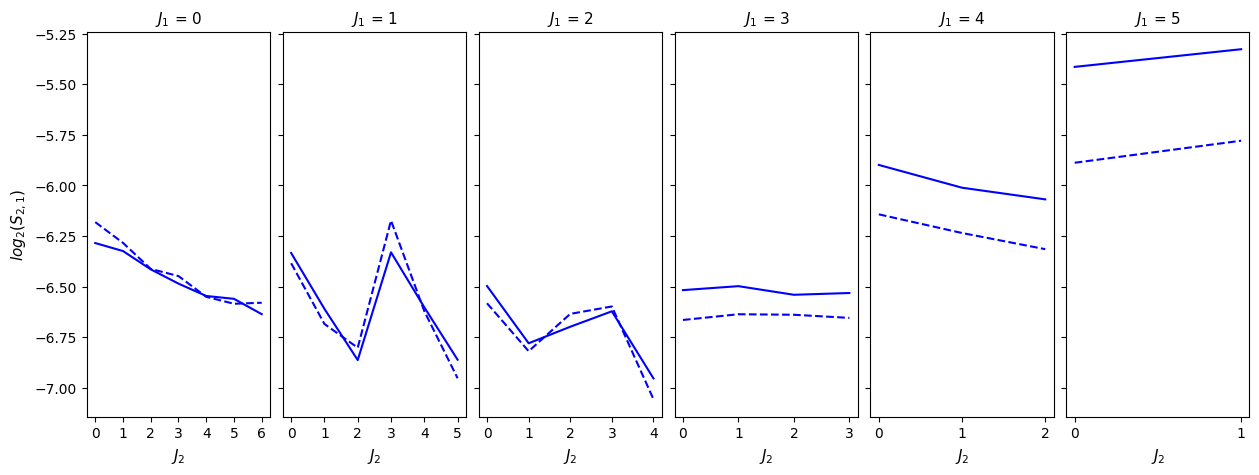

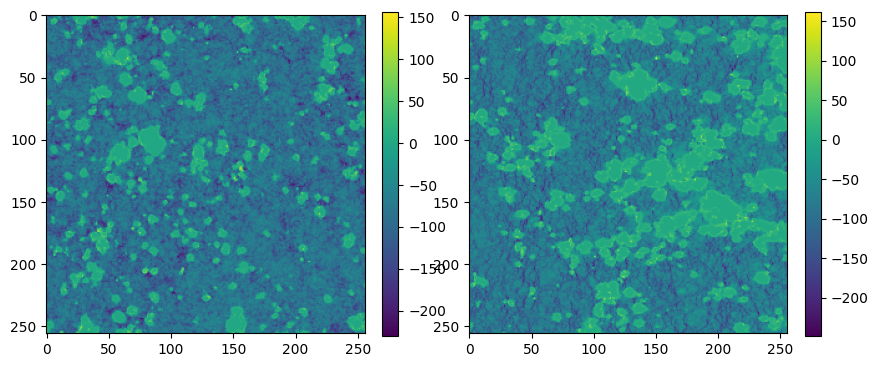

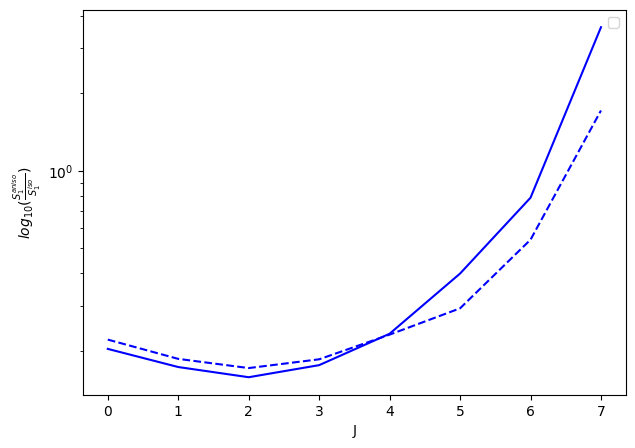

In [84]:
print(redshifts_100[5])
print(z[::-1][(1024+256):(1024+512)].max())
print(z[::-1][(1024+256):(1024+512)].min())
fig, axs = plt.subplots(1, len(Sparsity_5)-2, sharey=True,figsize=(15,5))
fig.subplots_adjust(wspace=0.07)
for i in range(len(Sparsity_1)-2):
    x = np.arange(len(Sparsity_5[i]))
    axs[i].plot(np.log2(Sparsity_5[i]),c = 'b' )
    axs[i].plot(np.log2(Sparsity_5_ls[i]),ls='--',c = 'b')
    axs[i].set_title('$J_{1}$ = '+ np.str(i),fontsize=11)
    axs[i].set_xlabel('$J_{2}$',fontsize=11)
    axs[i].set_xticks(x,fontsize=11)    
axs[0].set_ylabel('$log_2(S_{2,1})$',fontsize=11)

f, axarr = plt.subplots(1,2,figsize=(10, 10))
img = axarr[0].imshow(LC[5][0])
plt.colorbar(img, ax=axarr[0],fraction=0.046)
img = axarr[1].imshow(LC_ls[5][0])
plt.colorbar(img, ax=axarr[1],fraction=0.046)

plt.figure(figsize=(7,5))
plt.plot(Js,Anisotropy_5,c = 'b' )
plt.plot(Js_ls,Anisotropy_5_ls,ls='--',c = 'b')

plt.legend()
plt.xlabel('J')
plt.ylabel('$log_{10} (\\frac{S^{aniso}_{1}}{S^{iso}_{1}}$)')
plt.yscale('log')

/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


$\bar{z}$ =7.02
7.1435015806486
6.529689963215976


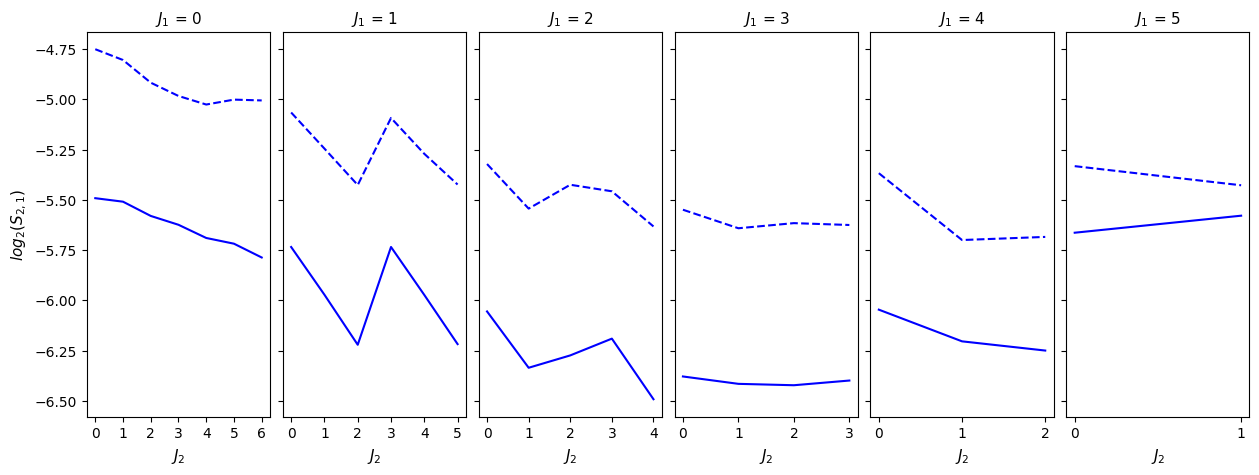

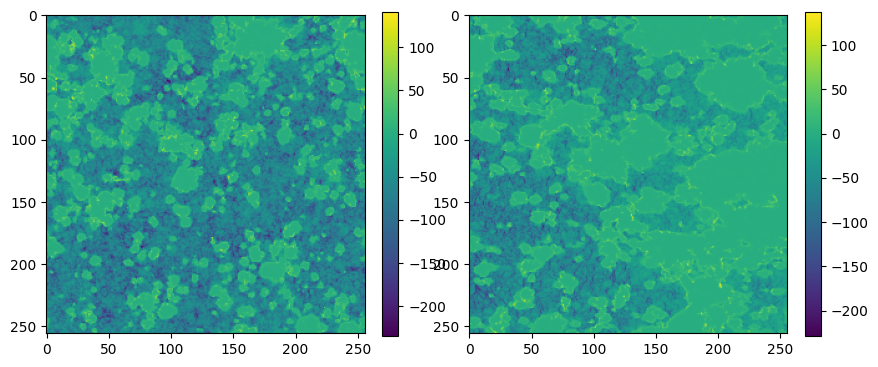

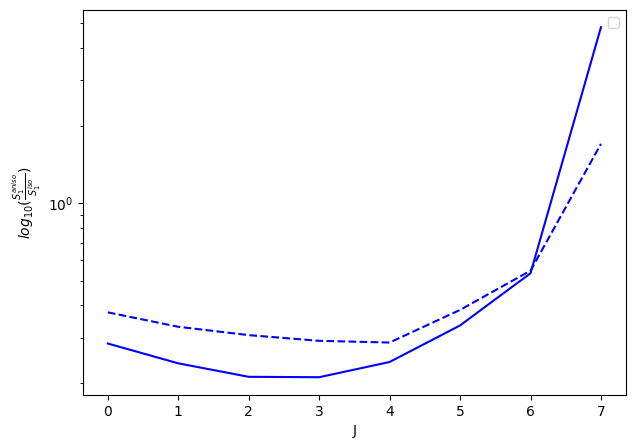

In [85]:
print(redshifts_100[6])
print(z[::-1][(1024+512):(1024+512+256)].max())
print(z[::-1][(1024+512):(1024+512+256)].min())
fig, axs = plt.subplots(1, len(Sparsity_6)-2, sharey=True,figsize=(15,5))
fig.subplots_adjust(wspace=0.07)
for i in range(len(Sparsity_6)-2):
    x = np.arange(len(Sparsity_6[i]))
    axs[i].plot(np.log2(Sparsity_6[i]),c = 'b' )
    axs[i].plot(np.log2(Sparsity_6_ls[i]),ls='--',c = 'b')
    axs[i].set_title('$J_{1}$ = '+ np.str(i),fontsize=11)
    axs[i].set_xlabel('$J_{2}$',fontsize=11)
    axs[i].set_xticks(x,fontsize=11)    
axs[0].set_ylabel('$log_2(S_{2,1})$',fontsize=11)

f, axarr = plt.subplots(1,2,figsize=(10, 10))
img = axarr[0].imshow(LC[6][0])
plt.colorbar(img, ax=axarr[0],fraction=0.046)
img = axarr[1].imshow(LC_ls[6][0])
plt.colorbar(img, ax=axarr[1],fraction=0.046)

plt.figure(figsize=(7,5))
plt.plot(Js,Anisotropy_6,c = 'b' )
plt.plot(Js_ls,Anisotropy_6_ls,ls='--',c = 'b')

plt.legend()
plt.xlabel('J')
plt.ylabel('$log_{10} (\\frac{S^{aniso}_{1}}{S^{iso}_{1}}$)')
plt.yscale('log')

/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


$\bar{z}$ =6.42
6.527464950586072
6.0


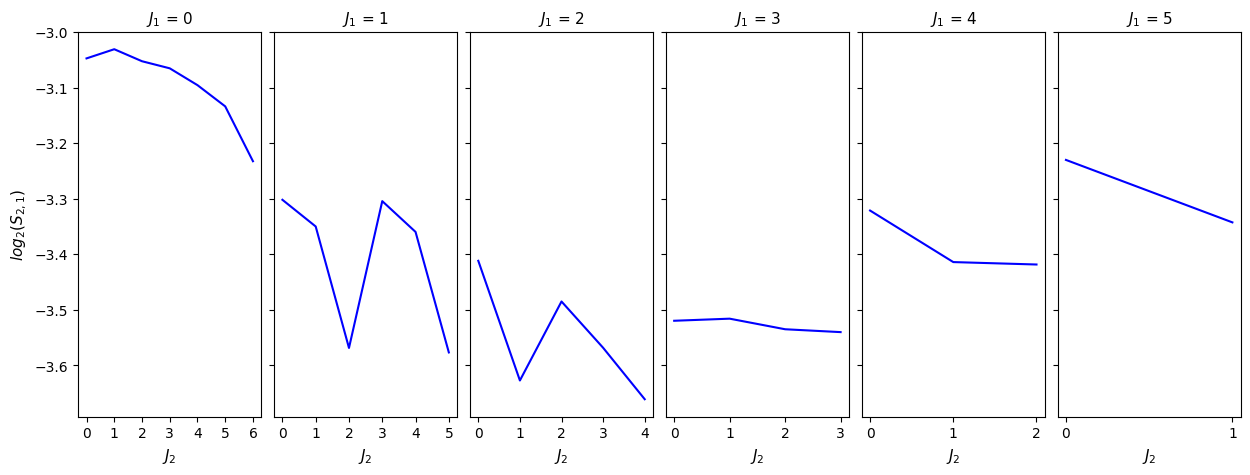

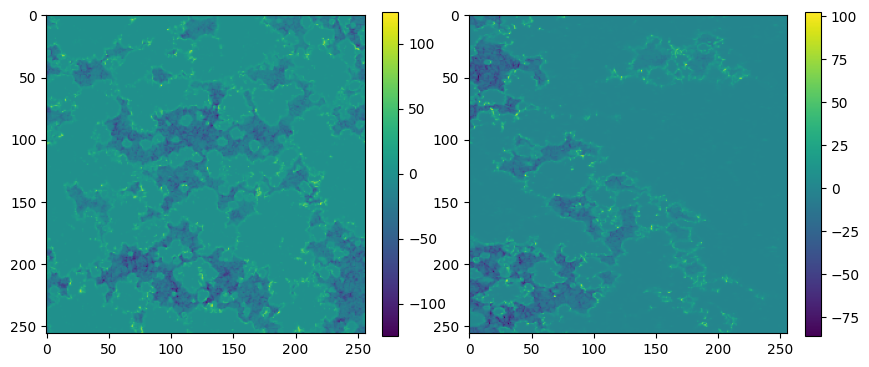

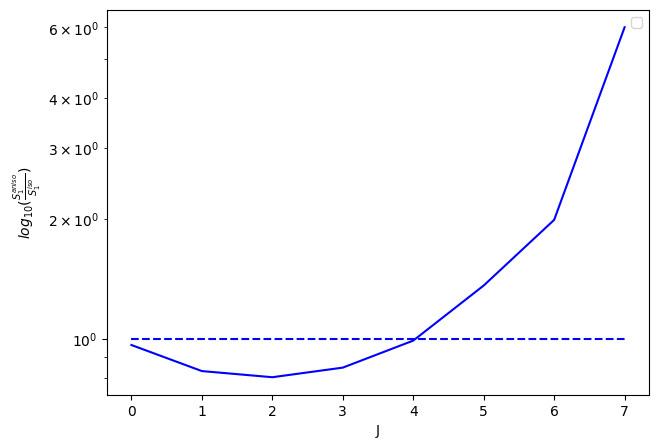

In [86]:
print(redshifts_100[7])
print(z[::-1][(1024+512+256):(1024+512+512)].max())
print(z[::-1][(1024+512+256):(1024+512+512)].min())
fig, axs = plt.subplots(1, len(Sparsity_7)-2, sharey=True,figsize=(15,5))
fig.subplots_adjust(wspace=0.07)
for i in range(len(Sparsity_7)-2):
    x = np.arange(len(Sparsity_7[i]))
    axs[i].plot(np.log2(Sparsity_7[i]),c = 'b' )
    axs[i].plot(np.log2(Sparsity_7_ls[i]),ls='--',c = 'b')
    axs[i].set_title('$J_{1}$ = '+ np.str(i),fontsize=11)
    axs[i].set_xlabel('$J_{2}$',fontsize=11)
    axs[i].set_xticks(x,fontsize=11)    
axs[0].set_ylabel('$log_2(S_{2,1})$',fontsize=11)

f, axarr = plt.subplots(1,2,figsize=(10, 10))
img = axarr[0].imshow(LC[7][0])
plt.colorbar(img, ax=axarr[0],fraction=0.046)
img = axarr[1].imshow(LC_ls[7][0])
plt.colorbar(img, ax=axarr[1],fraction=0.046)

plt.figure(figsize=(7,5))
plt.plot(Js,Anisotropy_7,c = 'b' )
plt.plot(Js_ls,Anisotropy_7_ls,ls='--',c = 'b')

plt.legend()
plt.xlabel('J')
plt.ylabel('$log_{10} (\\frac{S^{aniso}_{1}}{S^{iso}_{1}}$)')
plt.yscale('log')